In [ ]:
# ============================
# Cell 1: Imports & Config
# ============================
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor

# LLM client (optional)
os.environ["OPENAI_API_KEY"] = "sk-"
try:
    from openai import OpenAI
    client = OpenAI()   # needs OPENAI_API_KEY in env
except Exception:
    client = None
    print("⚠️ OpenAI client not initialised – LLM steps will use fallback.")


In [16]:
# ============================
# Cell 2: Load Data
# ============================
DATA_PATH = r"C:\Users\CYJ\Downloads\preprocessed_data.csv"   # adjust if needed

df = pd.read_csv(DATA_PATH)

target_col = "Q274: How many children do you have"

# numeric-only and drop rows where target is missing
num_df = df.select_dtypes(include=[np.number]).dropna(subset=[target_col]).reset_index(drop=True)

print("Data shape (numeric, target not null):", num_df.shape)
display(num_df.head())


Data shape (numeric, target not null): (2012, 287)


,N_REGION_ISO: Region ISO 3166-2,Q1: Important in life: Family,Q2: Important in life: Friends,Q3: Important in life: Leisure time,Q4: Important in life: Politics,Q5: Important in life: Work,Q6: Important in life: Religion,Q7: Important child qualities: good manners,Q8: Important child qualities: independence,Q9: Important child qualities: hard work,...,Q283: Respondent's Father - Occupational group (when respondent was 14 years old),Q284: Sector of employment,Q285: Are you the chief wage earner in your house,Q286: Family savings during past year,Q287: Social class (subjective),Q288: Scale of incomes,Q289: Religious denominations - major groups,Q290: Ethnic group,O1_LONGITUDE: Geographical Coordinates - Longitude,O2_LATITUDE: Geographical Coordinates - Latitude
0,702001.0,1.0,2.0,1.0,3.0,2.0,2.0,2.0,1.0,2.0,...,3.0,2.0,2.0,1.0,2.0,5.0,0.0,702004.0,103.82,1.23
1,702001.0,1.0,2.0,1.0,3.0,3.0,2.0,1.0,2.0,1.0,...,4.0,2.0,1.0,2.0,4.0,1.0,0.0,702004.0,103.81,1.23
2,702001.0,1.0,1.0,2.0,2.0,2.0,3.0,1.0,2.0,2.0,...,7.0,2.0,1.0,1.0,4.0,4.0,0.0,702004.0,103.84,1.22
3,702001.0,1.0,2.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0,...,1.0,2.0,2.0,1.0,3.0,6.0,0.0,702004.0,103.84,1.22
4,702001.0,1.0,1.0,1.0,4.0,1.0,2.0,1.0,1.0,1.0,...,5.0,2.0,2.0,1.0,2.0,8.0,5.0,702003.0,103.84,1.23


=== Feature–Target Correlation Table ===


,feature,corr_with_Q274
0,Q262: Age,0.460573
1,Q282: Respondent's Spouse - Occupational group,0.374442
2,Q280: Employment status - Respondent's Spouse,0.261248
3,Q270: Number of people in household,0.256193
4,Q206: Information source: Internet,0.248249
...,...,...
281,Q193: Justifiable: Having casual sex,-0.333497
282,Q182: Justifiable: Homosexuality,-0.341639
283,Q276: Highest educational level: Respondent's ...,-0.387900
284,Q261: Year of birth,-0.461840


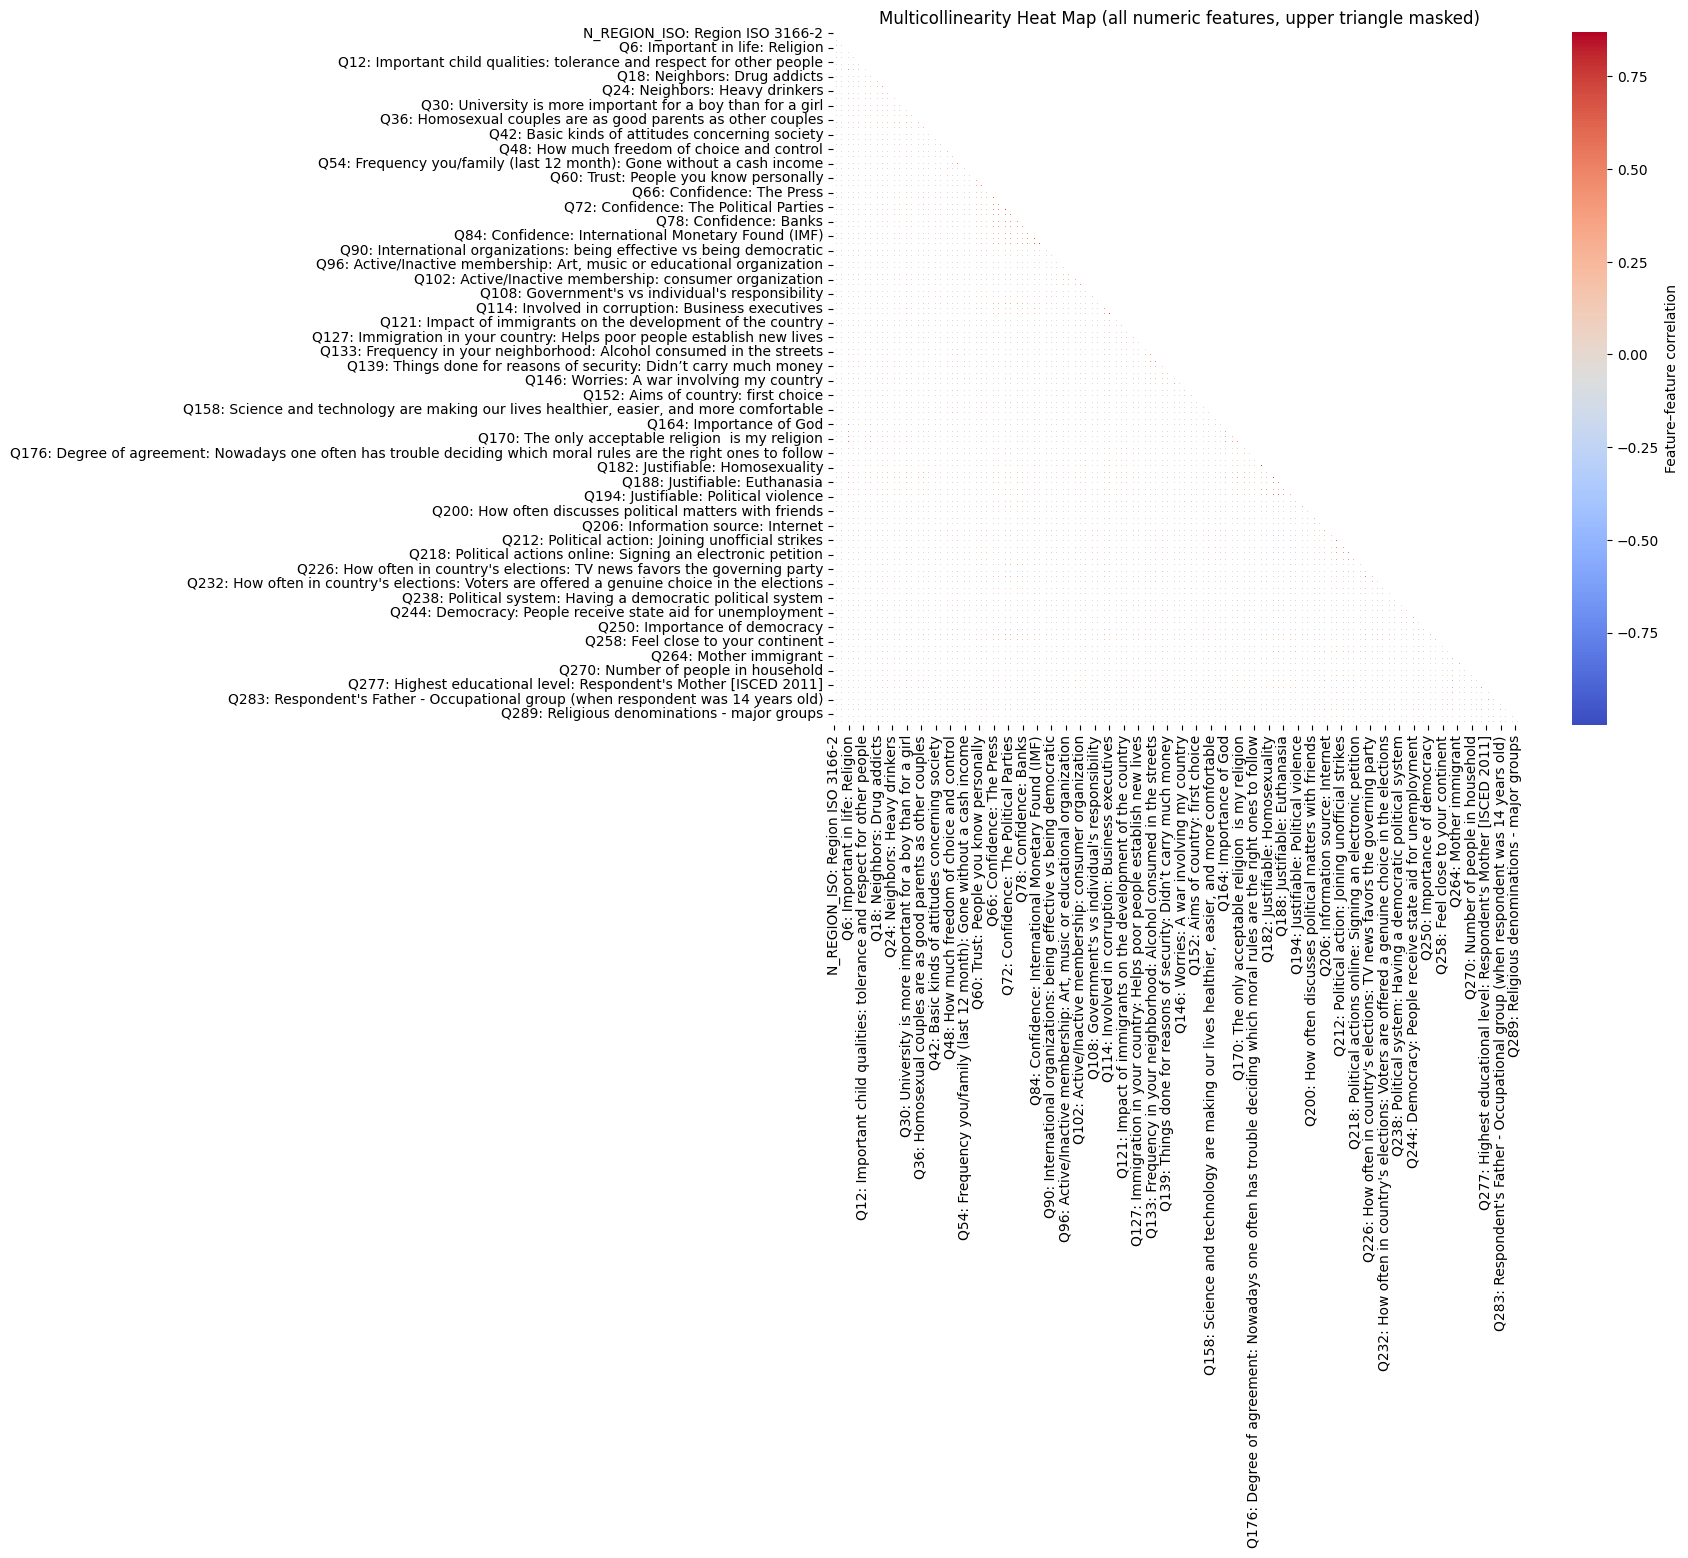


=== PCA Summary ===
- Original feature count: 286
- PCA components retained (95% variance): 222


,component,cumulative_explained_variance
0,1,0.071175
1,2,0.122667
2,3,0.152175
3,4,0.177654
4,5,0.202046
5,6,0.220603
6,7,0.237428
7,8,0.253322
8,9,0.267462
9,10,0.279701


In [17]:
# ============================
# Cell 3: PCA (Approach 4 only)
# ============================

# 1) correlation to target (for display)
corr_to_target = num_df.corr(numeric_only=True)[target_col].sort_values(ascending=False)

corr_table = (
    corr_to_target
    .drop(labels=[target_col])
    .reset_index()
    .rename(columns={"index": "feature", target_col: "corr_with_Q274"})
)

print("=== Feature–Target Correlation Table ===")
display(corr_table.sort_values(by="corr_with_Q274", ascending=False).reset_index(drop=True))

# 2) heatmap to SEE multicollinearity (not to select)
feature_cols_all = [c for c in num_df.columns if c != target_col]
heat_df = num_df[feature_cols_all + [target_col]]
corr_matrix = heat_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap="coolwarm",
    annot=False,
    linewidths=0.2,
    square=True,
    cbar_kws={"label": "Feature–feature correlation"}
)
plt.title("Multicollinearity Heat Map (all numeric features, upper triangle masked)")
plt.show()

# 3) PCA on ALL numeric features (excluding target)
X_all = num_df[feature_cols_all].copy()

scaler_pca = StandardScaler()
X_all_std = scaler_pca.fit_transform(X_all)

# keep 95% variance
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_all_std)

print("\n=== PCA Summary ===")
print(f"- Original feature count: {len(feature_cols_all)}")
print(f"- PCA components retained (95% variance): {pca.n_components_}")

# optional: show first few cumulative variances
cum_var = np.cumsum(pca.explained_variance_ratio_)
pca_var_df = pd.DataFrame({
    "component": np.arange(1, len(cum_var) + 1),
    "cumulative_explained_variance": cum_var
})
display(pca_var_df.head(15))

# NOTE:
# - later cells can choose to model on X_pca (recommended) or on num_df[feature_cols_all]



In [18]:
# ============================
# Cell 4: Build X/y and Split (using PCA)
# ============================

# Use the PCA-transformed data
X = X_pca.copy()                     # already standardized and orthogonal
y = num_df[target_col].copy()

# 70 / 15 / 15 split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# no extra StandardScaler needed here because PCA was done on standardized data



Train: (1408, 222), Val: (302, 222), Test: (302, 222)


In [19]:
# ============================
# Cell 5: Evaluation helper
# ============================
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

def evaluate_with_split_full(name, model, X_tr, y_tr, X_val, y_val, X_te, y_te):
    model.fit(X_tr, y_tr)
    preds = {
        "train": model.predict(X_tr),
        "validation": model.predict(X_val),
        "test": model.predict(X_te),
    }

    metrics = {"model": name}

    for split, (X_, y_, y_pred) in {
        "train": (X_tr, y_tr, preds["train"]),
        "validation": (X_val, y_val, preds["validation"]),
        "test": (X_te, y_te, preds["test"]),
    }.items():
        mse = mean_squared_error(y_, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_, y_pred)
        r2 = r2_score(y_, y_pred)
        adjr2 = adjusted_r2(r2, len(y_), X_.shape[1])

        print(f"\n==== {name} | {split.capitalize()} set ====")
        print(f"R²: {r2:.4f}")
        print(f"Adjusted R²: {adjr2:.4f}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")

        metrics[f"{split}_r2"] = r2
        metrics[f"{split}_adjr2"] = adjr2
        metrics[f"{split}_mse"] = mse
        metrics[f"{split}_rmse"] = rmse
        metrics[f"{split}_mae"] = mae

    print("\n" + "-" * 60)
    return model, metrics



In [20]:
# ============================
# Cell 6: LLM grid helper + fallback
# ============================
def get_fallback_grid(model_name: str):
    name = model_name.lower()
    if "ridge" in name:
        return {"alpha": [0.01, 0.1, 1.0, 10.0, 50.0]}
    if "lasso" in name:
        return {"alpha": [0.0005, 0.001, 0.01, 0.1], "max_iter": [5000]}
    if "elastic" in name:
        return {"alpha": [0.0005, 0.001, 0.01],
                "l1_ratio": [0.3, 0.5, 0.7],
                "max_iter": [5000]}
    if "random forest" in name:
        return {"n_estimators": [100, 200],
                "max_depth": [None, 5, 10],
                "min_samples_split": [2, 5]}
    return {}

def get_llm_grid(model_name: str):
    if client is None:
        return get_fallback_grid(model_name)

    prompt = f"""
    Suggest a very small sklearn-style hyperparameter grid (Python dict) for '{model_name}'
    to predict the number of children (Q274) from PCA components.
    Keep 3-6 combinations. Output ONLY the Python dict literal.
    """
    try:
        resp = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.2,
        )
        txt = resp.choices[0].message.content.strip()
        grid = json.loads(txt.replace("'", '"'))
        return grid
    except Exception:
        return get_fallback_grid(model_name)



In [21]:
# ============================
# Cell 7: GridSearch wrapper
# ============================
def tune_and_evaluate(
    name,
    estimator,
    X_train,
    y_train,
    X_val,
    y_val,
    X_test,
    y_test,
    use_llm_grid=True,
    cv=3
):
    if use_llm_grid:
        param_grid = get_llm_grid(name)
    else:
        param_grid = get_fallback_grid(name)

    if param_grid:
        print(f"\n>>> Running GridSearchCV for {name} with grid: {param_grid}")
        gs = GridSearchCV(
            estimator,
            param_grid=param_grid,
            cv=cv,
            scoring="r2",
            n_jobs=-1
        )
        gs.fit(X_train, y_train)
        best_model = gs.best_estimator_
        print(f"Best params for {name}: {gs.best_params_}")
    else:
        print(f"\n>>> No hyperparams to tune for {name}, fitting directly.")
        best_model = estimator.fit(X_train, y_train)

    best_model, metrics = evaluate_with_split_full(
        name,
        best_model,
        X_train, y_train,
        X_val, y_val,
        X_test, y_test
    )

    metrics["best_params"] = gs.best_params_ if param_grid else {}
    # with PCA we don't have per-feature names, so we can store component count
    metrics["n_pca_components"] = X_train.shape[1]
    return best_model, metrics


In [22]:
# ============================
# Cell 8: Train all models (on PCA features)
# ============================
results = []

# 1. OLS
ols = LinearRegression()
ols, m_ols = tune_and_evaluate(
    "Linear Regression (OLS, PCA)",
    ols,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    use_llm_grid=False   # OLS has no params
)
results.append(m_ols)

# 2. Ridge
ridge = Ridge(random_state=42)
ridge, m_ridge = tune_and_evaluate(
    "Ridge Regression (PCA)",
    ridge,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    use_llm_grid=True
)
results.append(m_ridge)

# 3. Lasso
lasso = Lasso(random_state=42)
lasso, m_lasso = tune_and_evaluate(
    "Lasso Regression (PCA)",
    lasso,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    use_llm_grid=True
)
results.append(m_lasso)

# 4. ElasticNet
elastic = ElasticNet(random_state=42)
elastic, m_elastic = tune_and_evaluate(
    "ElasticNet Regression (PCA)",
    elastic,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    use_llm_grid=True
)
results.append(m_elastic)

# 5. Random Forest (on PCA components)
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf, m_rf = tune_and_evaluate(
    "Random Forest Regressor (PCA)",
    rf,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    use_llm_grid=True
)
results.append(m_rf)



>>> No hyperparams to tune for Linear Regression (OLS, PCA), fitting directly.

==== Linear Regression (OLS, PCA) | Train set ====
R²: 0.6197
Adjusted R²: 0.5485
MSE: 0.6702
RMSE: 0.8186
MAE: 0.6144

==== Linear Regression (OLS, PCA) | Validation set ====
R²: 0.4274
Adjusted R²: -1.1818
MSE: 1.2210
RMSE: 1.1050
MAE: 0.8210

==== Linear Regression (OLS, PCA) | Test set ====
R²: 0.4969
Adjusted R²: -0.9168
MSE: 0.8686
RMSE: 0.9320
MAE: 0.6896

------------------------------------------------------------

>>> Running GridSearchCV for Ridge Regression (PCA) with grid: {'alpha': [0.01, 0.1, 1.0, 10.0, 50.0]}
Best params for Ridge Regression (PCA): {'alpha': 50.0}

==== Ridge Regression (PCA) | Train set ====
R²: 0.6190
Adjusted R²: 0.5476
MSE: 0.6715
RMSE: 0.8195
MAE: 0.6132

==== Ridge Regression (PCA) | Validation set ====
R²: 0.4352
Adjusted R²: -1.1521
MSE: 1.2044
RMSE: 1.0974
MAE: 0.8095

==== Ridge Regression (PCA) | Test set ====
R²: 0.5055
Adjusted R²: -0.8839
MSE: 0.8537
RMSE: 0.9

In [23]:
# ============================
# Cell 9: Results Table
# ============================
results_df = pd.DataFrame(results)

cols = [c for c in [
    "model",
    "train_r2", "train_adjr2",
    "validation_r2", "validation_adjr2",
    "test_r2", "test_adjr2",
    "test_rmse", "test_mae",
    "best_params",
    "n_pca_components",
] if c in results_df.columns]

display(
    results_df[cols].sort_values(by="validation_r2", ascending=False)
)


,model,train_r2,train_adjr2,validation_r2,validation_adjr2,test_r2,test_adjr2,test_rmse,test_mae,best_params,n_pca_components
3,ElasticNet Regression (PCA),0.610857,0.537954,0.438147,-1.140732,0.516914,-0.840621,0.913298,0.681199,"{'alpha': 0.01, 'l1_ratio': 0.7, 'max_iter': 5...",222
2,Lasso Regression (PCA),0.603336,0.529025,0.437474,-1.143295,0.517647,-0.837827,0.912605,0.683916,"{'alpha': 0.01, 'max_iter': 5000}",222
1,Ridge Regression (PCA),0.618965,0.547582,0.435160,-1.152112,0.505544,-0.883942,0.923984,0.682999,{'alpha': 50.0},222
0,"Linear Regression (OLS, PCA)",0.619745,0.548507,0.427378,-1.181762,0.496913,-0.916824,0.932012,0.689637,{},222
4,Random Forest Regressor (PCA),0.884827,0.863250,0.274018,-1.766084,0.266533,-1.794603,1.125358,0.892619,"{'max_depth': None, 'min_samples_split': 5, 'n...",222


In [24]:
# ============================
# Cell 10: LLM Commentary (optional)
# ============================
def call_llm_on_results_full(results):
    if client is None:
        print("LLM not available — skipping commentary.")
        return
    txt = json.dumps(results, indent=2)
    prompt = f"""
    Here are regression results trained on PCA components (so no multicollinearity).
    Please:
    1. Identify the best-generalizing model.
    2. Flag overfitting (train >> validation/test).
    3. Suggest 1-2 next improvements.
    {txt}
    """
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.3,
    )
    print("\n=== 🤖 LLM Commentary ===\n")
    print(resp.choices[0].message.content)

call_llm_on_results_full(results)




=== 🤖 LLM Commentary ===

Based on the provided regression results, here are the analyses and suggestions:

### 1. Identify the Best-Generalizing Model
The best-generalizing model is the **Lasso Regression (PCA)**. It has the highest validation R² score (0.4375) among the models, indicating it generalizes better to unseen data compared to the others. It also has a relatively good performance on the test set with an R² of 0.5176.

### 2. Flag Overfitting
The **Random Forest Regressor (PCA)** shows clear signs of overfitting. The training R² (0.8848) is significantly higher than the validation R² (0.2740) and test R² (0.2665). This large discrepancy indicates that the model is fitting the training data too closely and failing to generalize to new data.

### 3. Suggest 1-2 Next Improvements
- **Hyperparameter Tuning**: For models like Ridge, Lasso, and ElasticNet, further tuning of hyperparameters (e.g., using cross-validation) could improve performance. For instance, exploring a wider r